In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

import logging
import warnings
from functools import partial

In [15]:
def simulate_gandk(theta, num_samples, c = 0.8):
    zu = np.random.randn(num_samples,1)
    f = (theta[0] + theta[1] * (1 + c * (1 - np.exp(-theta[2] * zu)) / (1 + np.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

def compute_summary_statistics(y):
    quant_y = []
    for i in np.arange(0.125, 1, 0.125):
        quant_y.append(np.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return np.array([Sa, Sb, Sc, Sd])

In [16]:
true_theta = np.array([3, 1, 2, 0.5])
num_coeffs = 4
num_latent = 4
num_datasets = 200
num_samples = 200

In [17]:
actual_data = simulate_gandk(true_theta, num_samples)
actual_data

array([[ 3.0269255 ],
       [ 2.22807967],
       [ 2.58857857],
       [ 3.89966692],
       [ 2.28511364],
       [ 5.58419211],
       [ 2.51893737],
       [ 2.42864763],
       [ 2.82293732],
       [ 3.38644719],
       [ 4.90125982],
       [ 2.78053381],
       [ 2.16689532],
       [ 2.51614249],
       [ 3.40985058],
       [ 3.18228411],
       [ 3.59479316],
       [ 4.7055079 ],
       [ 2.82342177],
       [ 3.80718001],
       [ 2.80031972],
       [ 3.40468992],
       [ 2.86684997],
       [ 3.54816153],
       [ 4.50061648],
       [ 4.45844557],
       [ 4.11201045],
       [ 2.82782263],
       [ 5.31691615],
       [ 3.06632279],
       [ 2.63919009],
       [ 2.36760414],
       [ 2.75450016],
       [ 2.77268654],
       [ 2.74406111],
       [ 2.33581108],
       [ 7.12485216],
       [ 2.74685121],
       [ 4.96919404],
       [ 2.77517893],
       [ 2.61536982],
       [ 5.66776205],
       [ 3.17303073],
       [ 3.01971178],
       [ 3.32622516],
       [ 3

In [18]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

array([3.00663801, 1.38064096, 0.45029091, 2.03572641])

In [26]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

## Training Wasserstein Gaussianing

In [19]:
wass_num_datasets = 6000
wass_n_samples = 100
maxG = 3

In [20]:
wass_n_summary_statistics = np.zeros((wass_num_datasets, num_latent))
for i in range(0, wass_num_datasets):
    y = simulate_gandk(true_theta, num_samples)
    wass_n_summary_statistics[i,:] = compute_summary_statistics(y)

In [27]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [22]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in np.arange(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-5).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = np.argmin(bic_values) + 1
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-5).fit(data)
    mean_mixture_obj = best_mixture_obj.means_
    sigma_mixture_obj = best_mixture_obj.covariances_
    weights_mixture_obj = best_mixture_obj.weights_
    return best_mixture_obj, bestG, np.array(mean_mixture_obj), np.array(sigma_mixture_obj), np.array(weights_mixture_obj)

In [23]:
def grad_log_density_mixture(data, mean_mixture_obj, sigma_mixture_obj, weights_mixture_obj):
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k] 
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(np.log(weight_kth_mixture) - num_coeffs/2 * np.log(2 * np.pi)-1/2 * np.log(np.linalg.det(sigma_kth_mixture)) - 1/2 * np.diag(diff_mean_kth_mixture @ my_inv(sigma_kth_mixture) @ diff_mean_kth_mixture.T)) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ my_inv(sigma_kth_mixture)) #M =99 x dim of ss =4

    max_llh_all_data = np.max(loglh_all_mixture, axis = 0) # 99 x 1
    aux_llh_all_data = loglh_all_mixture - max_llh_all_data #g x 99
    w_all_data = np.exp(aux_llh_all_data) / np.sum(np.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = np.log(np.sum(np.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):    
        grad_log_f = grad_log_f + np.tile(np.reshape(w_all_data[k,:], (len(data),1)),(1,len(actual_summary_statistics))) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [28]:
# Start training

# Hyperparams
patience_max = 5
patience = 0 
stop = 5000
eps = 0.01
t_w = 20

# Initialize empty chain
mixture_obj_seq = []
bestG_seq = []
lb = []
LB_Smoothed = []

# At current particles, fit mixture normal
mixture_model = mixture_model_fit(original_train_summary_statistics, maxG)
mixture_obj_seq.append(mixture_model[0])
bestG_seq.append(mixture_model[1])

In [29]:
for t in range(stop):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * np.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f 

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_model = mixture_model_fit(wass_train_summary_statistics, maxG)
    mixture_obj = mixture_model[0]
    bestG = mixture_model[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq.append(mixture_obj)
    bestG_seq.append(bestG)

    lb.append(np.mean(h_vector))

    if t < t_w:
        print('LB', np.mean(h_vector))

    if t >= t_w:
        LB_smoothed = np.mean(lb[t - t_w + 1 : t])
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= np.max(LB_Smoothed):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break

LB -10.431884975583875
LB -6.752486042199152
LB -6.162995102746154
LB -5.700268441391692
LB -5.3092081391415835
LB -4.966123363653178
LB -4.658122329995003
LB -4.377248395104331
LB -4.118179842263417
LB -3.877150896193419
LB -3.651382482155276
LB -3.4387555683491513
LB -3.2376114261285447
LB -3.0466232593920224
LB -2.8647103184409035
LB -2.690978499702766
LB -2.5246781019270474
LB -2.3651730603506746
LB -2.21191807487988
LB -2.0644412988145895
LB Smoothed -3.8956870864646724
LB Smoothed -3.6414684014661383
LB Smoothed -3.4110594653154287
LB Smoothed -3.1980350096072603
LB Smoothed -2.998854637049503
LB Smoothed -2.811211381608205
LB Smoothed -2.633464675725785
LB Smoothed -2.464381757991567
LB Smoothed -2.3029999906281935
LB Smoothed -2.148545837062939
LB Smoothed -2.0003836915521287
LB Smoothed -1.8580073446185592
LB Smoothed -1.720904400885084
LB Smoothed -1.588722260966229
LB Smoothed -1.461123483610466
LB Smoothed -1.3378120275554617
LB Smoothed -1.2185260287002548
LB Smoothed -1.1

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

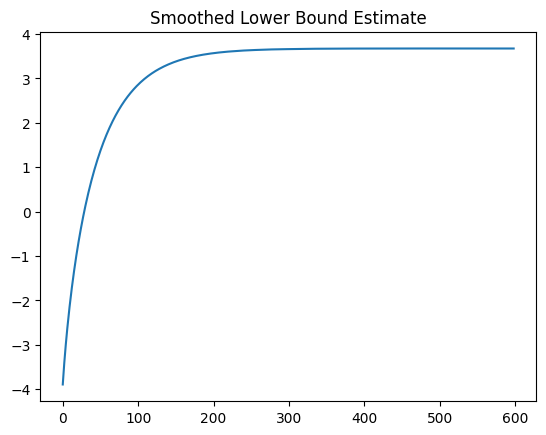

In [30]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [33]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        mean_mixture_obj = mixture_obj.means_
        sigma_mixture_obj = mixture_obj.covariances_
        weights_mixture_obj = mixture_obj.weights_
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mean_mixture_obj, sigma_mixture_obj, weights_mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

In [34]:
def summary_statistics(theta, num_samples, num_datasets):
    n_summary_statistics = np.zeros((num_datasets, num_latent))
    for i in range(0, num_datasets):
        y = simulate_gandk(theta, num_samples)
        n_summary_statistics[i,:] = compute_summary_statistics(y)
    transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(transformed_summary_statistics).T)
    return sample_mean, sample_variance

In [35]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

def unbiased_log_likelihood(theta):
    ss = summary_statistics(theta, num_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1

    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

    return u_est_log_likelihood

In [36]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([true_theta[0], np.log(true_theta[1]), true_theta[2], np.log(true_theta[3])])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        l_0 = np.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                        [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                        [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                        [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                rng = np.random.default_rng()
                theta_0_samples = rng.multivariate_normal(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    # alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    # beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    # gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))

                    alpha_0 = theta_tilde_0[0]
                    # beta_q = (0.05 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    beta_0 = np.exp(theta_tilde_0[1])
                    # gamma_q = (np.exp(theta_tilde_q[2]) - 1) / (1 + np.exp(theta_tilde_q[2]))
                    gamma_0 = theta_tilde_0[2]
                    # delta_q = (0.5 * np.exp(theta_tilde_q[3]) + 0.2) / (1 + np.exp(theta_tilde_q[3]))                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    delta_0 = np.exp(theta_tilde_0[3])

                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                rng = np.random.default_rng()
                theta_q_samples = rng.multivariate_normal(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = theta_tilde_q[0]
                    # beta_q = (0.05 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    beta_q = np.exp(theta_tilde_q[1])
                    # gamma_q = (np.exp(theta_tilde_q[2]) - 1) / (1 + np.exp(theta_tilde_q[2]))
                    gamma_q = theta_tilde_q[2]
                    # delta_q = (0.5 * np.exp(theta_tilde_q[3]) + 0.2) / (1 + np.exp(theta_tilde_q[3]))                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    delta_q = np.exp(theta_tilde_q[3])

                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [37]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[3.00663801, 1.38064096, 0.45029091, 2.03572641]])

In [38]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)
transformed_summary_statistics[0]

array([ 1.26862087, -1.078422  ,  0.79952161,  0.87530655])

In [39]:
# Set hyperparameters
stop = 5000
vb = GVB(400, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [07:37<635:48:19, 457.87s/it]

LB -25.544148682953256


  0%|          | 2/5000 [17:39<752:41:16, 542.15s/it]

LB -24.839777484138814


  0%|          | 3/5000 [24:27<667:40:43, 481.02s/it]

LB -24.275729912814267


  0%|          | 4/5000 [32:39<673:48:14, 485.53s/it]

LB -24.209946861505358


  0%|          | 5/5000 [40:18<660:29:41, 476.03s/it]

LB -23.844699318657852


  0%|          | 6/5000 [47:22<635:43:44, 458.27s/it]

LB -23.483253834141205


  0%|          | 7/5000 [53:42<599:55:46, 432.55s/it]

LB -23.649061866986603


  0%|          | 8/5000 [59:45<569:12:34, 410.49s/it]

LB -22.95359802181845


  0%|          | 9/5000 [1:05:51<549:56:29, 396.67s/it]

LB -22.952125393786694


  0%|          | 10/5000 [1:12:16<544:33:36, 392.87s/it]

LB -22.623229464378614


  0%|          | 11/5000 [1:18:43<542:08:05, 391.20s/it]

LB -22.252382684186014


  0%|          | 12/5000 [1:25:59<560:47:19, 404.74s/it]

LB -21.821278577355375


  0%|          | 13/5000 [1:32:26<553:12:39, 399.35s/it]

LB -21.833228409696943


  0%|          | 14/5000 [1:39:27<562:08:23, 405.88s/it]

LB -21.496386164894474


  0%|          | 15/5000 [1:51:09<685:43:50, 495.21s/it]

LB -21.317455743035563


  0%|          | 16/5000 [1:57:45<644:04:48, 465.23s/it]

LB -21.41908355989228


  0%|          | 17/5000 [2:03:41<598:47:21, 432.60s/it]

LB -21.07987841043678


  0%|          | 18/5000 [2:09:37<566:31:21, 409.37s/it]

LB -21.032523137090678


  0%|          | 19/5000 [2:15:51<551:57:56, 398.93s/it]

LB -20.975035293429368


  0%|          | 20/5000 [2:22:03<540:26:39, 390.68s/it]

LB -20.98841256225909


  0%|          | 21/5000 [2:28:00<526:35:16, 380.74s/it]

LB -20.53908833337796


  0%|          | 22/5000 [2:33:51<514:09:29, 371.83s/it]

LB -20.484325470779094


  0%|          | 23/5000 [2:39:45<506:24:53, 366.30s/it]

LB -20.522622426078023


  0%|          | 24/5000 [2:45:30<497:24:57, 359.87s/it]

LB -19.95979936271335


  0%|          | 25/5000 [2:51:25<495:26:51, 358.51s/it]

LB -19.979040091253477


  1%|          | 26/5000 [2:54:16<417:37:49, 302.27s/it]

LB -19.917319216915317


  1%|          | 27/5000 [2:56:07<338:26:13, 245.00s/it]

LB -20.063586062116766


  1%|          | 28/5000 [2:58:00<283:42:02, 205.41s/it]

LB -19.517454609812788


  1%|          | 29/5000 [2:59:52<244:36:29, 177.15s/it]

LB -19.56551705216329


  1%|          | 30/5000 [3:01:58<223:34:21, 161.94s/it]

LB -19.234500602929128


  1%|          | 31/5000 [3:04:14<212:56:39, 154.28s/it]

LB -19.343494014039162


  1%|          | 32/5000 [3:06:14<198:27:59, 143.82s/it]

LB -19.196723208168887


  1%|          | 33/5000 [3:08:13<188:16:12, 136.46s/it]

LB -18.971200591720336


  1%|          | 34/5000 [3:10:33<189:46:02, 137.57s/it]

LB -19.059016622983492


  1%|          | 35/5000 [3:12:33<182:15:40, 132.15s/it]

LB -18.896376040134445


  1%|          | 36/5000 [3:14:29<175:45:12, 127.46s/it]

LB -18.677451665010178


  1%|          | 37/5000 [3:16:17<167:43:23, 121.66s/it]

LB -18.656589193897474


  1%|          | 38/5000 [3:18:11<164:29:48, 119.34s/it]

LB -18.66428510757161


  1%|          | 39/5000 [3:20:13<165:14:09, 119.91s/it]

LB -18.767596203156774


  1%|          | 40/5000 [3:22:08<163:11:47, 118.45s/it]

LB -18.54721621518738


  1%|          | 41/5000 [3:24:01<160:56:31, 116.84s/it]

LB -18.57479320224974


  1%|          | 42/5000 [3:25:49<157:28:11, 114.34s/it]

LB -18.50140125944475


  1%|          | 43/5000 [3:27:39<155:24:13, 112.86s/it]

LB -18.35539490696168


  1%|          | 44/5000 [3:29:27<153:37:51, 111.60s/it]

LB -18.20816056890667


  1%|          | 45/5000 [3:31:18<153:19:04, 111.39s/it]

LB -18.190923266611684


  1%|          | 46/5000 [3:33:10<153:15:16, 111.37s/it]

LB -18.24129352391347


  1%|          | 47/5000 [3:34:57<151:27:26, 110.08s/it]

LB -18.045740273658517


  1%|          | 48/5000 [3:36:44<150:12:37, 109.20s/it]

LB -18.1787491548641


  1%|          | 49/5000 [3:38:34<150:30:59, 109.44s/it]

LB -18.12027201626365


  1%|          | 50/5000 [3:40:20<149:14:33, 108.54s/it]

LB -17.976149206782413


  1%|          | 51/5000 [3:42:10<149:42:37, 108.90s/it]

LB Smoothed -20.367411554493263


  1%|          | 52/5000 [3:43:57<148:57:35, 108.38s/it]

LB Smoothed -20.23001552834554


  1%|          | 53/5000 [3:45:44<148:11:18, 107.84s/it]

LB Smoothed -20.099036957313547


  1%|          | 54/5000 [3:47:35<149:29:27, 108.81s/it]

LB Smoothed -19.969744580321862


  1%|          | 55/5000 [3:49:24<149:27:20, 108.80s/it]

LB Smoothed -19.84796696126896


  1%|          | 56/5000 [3:51:10<148:16:54, 107.97s/it]

LB Smoothed -19.732351951438016


  1%|          | 57/5000 [3:53:00<149:23:45, 108.81s/it]

LB Smoothed -19.611986223418818


  1%|          | 58/5000 [3:54:51<150:16:21, 109.47s/it]

LB Smoothed -19.50812331818312


  1%|          | 59/5000 [3:56:39<149:24:01, 108.85s/it]

LB Smoothed -19.403809006885965


  1%|          | 60/5000 [3:58:30<150:31:29, 109.69s/it]

LB Smoothed -19.303494690321934


  1%|          | 61/5000 [4:00:19<150:08:52, 109.44s/it]

LB Smoothed -19.212359187862685


  1%|          | 62/5000 [4:01:44<139:53:47, 101.99s/it]

LB Smoothed -19.13024487609196


  1%|▏         | 63/5000 [4:03:24<139:08:57, 101.47s/it]

LB Smoothed -19.046293695492928


  1%|▏         | 64/5000 [4:04:42<129:31:42, 94.47s/it] 

LB Smoothed -18.969313849130305


  1%|▏         | 65/5000 [4:06:03<123:42:46, 90.25s/it]

LB Smoothed -18.896743093939854


  1%|▏         | 66/5000 [4:07:29<122:12:54, 89.17s/it]

LB Smoothed -18.818315170474904


  1%|▏         | 67/5000 [4:08:56<121:09:15, 88.42s/it]

LB Smoothed -18.747820203762657


  1%|▏         | 68/5000 [4:10:28<122:39:59, 89.54s/it]

LB Smoothed -18.676079904981744


  1%|▏         | 69/5000 [4:11:50<119:41:52, 87.39s/it]

LB Smoothed -18.606358126061576


  1%|▏         | 70/5000 [4:13:07<115:02:23, 84.00s/it]

LB Smoothed -18.535820223917753


  1%|▏         | 71/5000 [4:14:23<111:44:30, 81.61s/it]

LB Smoothed -18.475022518126796


  1%|▏         | 72/5000 [4:15:39<109:32:17, 80.02s/it]

LB Smoothed -18.415292771927678


  1%|▏         | 73/5000 [4:16:56<108:20:15, 79.16s/it]

LB Smoothed -18.355475978122055


  1%|▏         | 74/5000 [4:18:38<117:32:41, 85.90s/it]

LB Smoothed -18.306173486713334


  2%|▏         | 75/5000 [4:20:21<124:43:11, 91.17s/it]

LB Smoothed -18.255088116724465


  2%|▏         | 76/5000 [4:22:09<131:39:39, 96.26s/it]

LB Smoothed -18.204530214044812


  2%|▏         | 77/5000 [4:23:56<135:50:45, 99.34s/it]

LB Smoothed -18.15183296401252


  2%|▏         | 78/5000 [4:25:40<137:38:55, 100.68s/it]

LB Smoothed -18.10999550951019


  2%|▏         | 79/5000 [4:27:28<140:50:08, 103.03s/it]

LB Smoothed -18.06651548291543


  2%|▏         | 80/5000 [4:29:12<141:19:44, 103.41s/it]

LB Smoothed -18.030789088874823


  2%|▏         | 81/5000 [4:30:56<141:17:04, 103.40s/it]

LB Smoothed -17.99291349924361


  2%|▏         | 82/5000 [4:32:41<142:02:25, 103.97s/it]

LB Smoothed -17.95717523694782


  2%|▏         | 83/5000 [4:34:27<142:36:15, 104.41s/it]

LB Smoothed -17.92563743169955


  2%|▏         | 84/5000 [4:36:11<142:33:22, 104.39s/it]

LB Smoothed -17.89122488715761


  2%|▏         | 85/5000 [4:37:56<142:41:26, 104.51s/it]

LB Smoothed -17.8606344465783


  2%|▏         | 86/5000 [4:39:42<143:34:44, 105.19s/it]

LB Smoothed -17.833935299437833


  2%|▏         | 87/5000 [4:41:13<137:27:16, 100.72s/it]

LB Smoothed -17.80974111740243


  2%|▏         | 88/5000 [4:42:37<130:28:23, 95.62s/it] 

LB Smoothed -17.78307824081337


  2%|▏         | 89/5000 [4:44:00<125:26:19, 91.95s/it]

LB Smoothed -17.757320996815803


  2%|▏         | 90/5000 [4:45:23<121:58:56, 89.44s/it]

LB Smoothed -17.734133541746104


  2%|▏         | 91/5000 [4:46:49<120:14:05, 88.17s/it]

LB Smoothed -17.709674821786937


  2%|▏         | 92/5000 [4:48:13<118:34:21, 86.97s/it]

LB Smoothed -17.68661955778796


  2%|▏         | 93/5000 [4:49:37<117:13:08, 86.00s/it]

LB Smoothed -17.66794301770782


  2%|▏         | 94/5000 [4:51:00<116:01:44, 85.14s/it]

LB Smoothed -17.649728208979557


  2%|▏         | 95/5000 [4:52:21<114:35:16, 84.10s/it]

LB Smoothed -17.633241782419542


  2%|▏         | 96/5000 [4:53:46<114:38:42, 84.16s/it]

LB Smoothed -17.617112434114787


  2%|▏         | 97/5000 [4:55:10<114:48:46, 84.30s/it]

LB Smoothed -17.605484245801183


  2%|▏         | 98/5000 [4:56:33<114:07:48, 83.82s/it]

LB Smoothed -17.590968049410296


  2%|▏         | 99/5000 [4:57:57<114:11:04, 83.87s/it]

LB Smoothed -17.579985182388384


  2%|▏         | 100/5000 [4:59:20<113:45:53, 83.58s/it]

LB Smoothed -17.572941945466397


  2%|▏         | 101/5000 [5:00:44<113:45:25, 83.59s/it]

LB Smoothed -17.559960922474886


  2%|▏         | 102/5000 [5:02:07<113:36:55, 83.51s/it]

LB Smoothed -17.553337020796704


  2%|▏         | 103/5000 [5:03:32<114:09:29, 83.92s/it]

LB Smoothed -17.54801571294041


  2%|▏         | 104/5000 [5:04:55<114:03:26, 83.87s/it]

LB Smoothed -17.54094805777216


  2%|▏         | 105/5000 [5:06:19<113:57:29, 83.81s/it]

LB Smoothed -17.536111740542488


  2%|▏         | 106/5000 [5:07:43<113:54:07, 83.79s/it]

LB Smoothed -17.531702489382557


  2%|▏         | 107/5000 [5:09:08<114:26:07, 84.20s/it]

LB Smoothed -17.522993876508785


  2%|▏         | 108/5000 [5:10:38<116:54:14, 86.03s/it]

LB Smoothed -17.515973762413886


  2%|▏         | 109/5000 [5:12:15<121:20:53, 89.32s/it]

LB Smoothed -17.510321833657795


  2%|▏         | 110/5000 [5:13:46<122:03:35, 89.86s/it]

LB Smoothed -17.501853417178044


  2%|▏         | 111/5000 [5:15:17<122:09:35, 89.95s/it]

LB Smoothed -17.494255276873094


  2%|▏         | 112/5000 [5:16:44<120:55:59, 89.07s/it]

LB Smoothed -17.488706663820963


  2%|▏         | 113/5000 [5:18:15<121:47:30, 89.72s/it]

LB Smoothed -17.481645466295554


  2%|▏         | 114/5000 [5:19:42<120:41:24, 88.92s/it]

LB Smoothed -17.476107584218024


  2%|▏         | 115/5000 [5:21:04<117:47:56, 86.81s/it]

LB Smoothed -17.473502579094692


  2%|▏         | 116/5000 [5:22:27<116:08:46, 85.61s/it]

LB Smoothed -17.470460245176433


  2%|▏         | 117/5000 [5:24:06<121:39:22, 89.69s/it]

LB Smoothed -17.468652980985375


  2%|▏         | 118/5000 [5:25:51<127:45:58, 94.22s/it]

LB Smoothed -17.466776114757693


  2%|▏         | 119/5000 [5:27:41<134:10:35, 98.96s/it]

LB Smoothed -17.46603354274978


  2%|▏         | 120/5000 [5:29:08<129:24:46, 95.47s/it]

LB Smoothed -17.463373467074923


  2%|▏         | 121/5000 [5:31:04<137:53:36, 101.75s/it]

LB Smoothed -17.46400119969221


  2%|▏         | 122/5000 [5:32:48<138:49:51, 102.46s/it]

LB Smoothed -17.461385275810677


  2%|▏         | 123/5000 [5:34:18<133:21:40, 98.44s/it] 

LB Smoothed -17.457714643591608


  2%|▏         | 124/5000 [5:35:53<131:56:58, 97.42s/it]

LB Smoothed -17.456491184537555


  2%|▎         | 125/5000 [5:37:19<127:34:27, 94.21s/it]

LB Smoothed -17.455930915506165


  3%|▎         | 126/5000 [5:38:37<120:49:50, 89.25s/it]

LB Smoothed -17.453730496556975


  3%|▎         | 127/5000 [5:39:52<115:08:11, 85.06s/it]

LB Smoothed -17.4512731122777


  3%|▎         | 128/5000 [5:41:24<118:01:24, 87.21s/it]

LB Smoothed -17.450819708533754


  3%|▎         | 129/5000 [5:43:07<124:05:29, 91.71s/it]

LB Smoothed -17.44943564887111


  3%|▎         | 130/5000 [5:44:41<125:16:49, 92.61s/it]

LB Smoothed -17.447259088303937


  3%|▎         | 131/5000 [5:46:05<121:30:20, 89.84s/it]

LB Smoothed -17.447166584444314


  3%|▎         | 132/5000 [5:47:35<121:39:43, 89.97s/it]

LB Smoothed -17.44698289095753


  3%|▎         | 133/5000 [5:49:03<120:49:20, 89.37s/it]

LB Smoothed -17.44768656232561


  3%|▎         | 134/5000 [5:50:31<120:07:20, 88.87s/it]

LB Smoothed -17.44865265095562


  3%|▎         | 135/5000 [5:51:49<115:56:54, 85.80s/it]

LB Smoothed -17.448744116497448


  3%|▎         | 136/5000 [5:53:48<129:21:00, 95.74s/it]

LB Smoothed -17.446116572341122


  3%|▎         | 137/5000 [5:55:20<127:50:49, 94.64s/it]

LB Smoothed -17.444643319176343


  3%|▎         | 138/5000 [5:56:51<126:21:09, 93.56s/it]

LB Smoothed -17.442385228045286


  3%|▎         | 139/5000 [5:58:49<136:14:41, 100.90s/it]

LB Smoothed -17.44364094727972


  3%|▎         | 140/5000 [6:00:41<140:32:30, 104.11s/it]

LB Smoothed -17.445818612463096


  3%|▎         | 141/5000 [6:02:33<143:46:04, 106.52s/it]

LB Smoothed -17.44730316086136


  3%|▎         | 142/5000 [6:04:19<143:35:17, 106.41s/it]

LB Smoothed -17.446189905279503


  3%|▎         | 143/5000 [6:05:57<140:01:38, 103.79s/it]

LB Smoothed -17.44916535316087


  3%|▎         | 144/5000 [6:07:43<140:44:01, 104.33s/it]

LB Smoothed -17.44828510885592


  3%|▎         | 145/5000 [6:09:28<140:57:07, 104.52s/it]

LB Smoothed -17.44734661552288


  3%|▎         | 146/5000 [6:11:16<142:27:14, 105.65s/it]

LB Smoothed -17.446353671732425


  3%|▎         | 147/5000 [6:12:56<140:19:56, 104.10s/it]

LB Smoothed -17.445547840051702


  3%|▎         | 148/5000 [6:14:37<138:50:37, 103.02s/it]

LB Smoothed -17.442226478907916


  3%|▎         | 149/5000 [6:16:28<142:09:09, 105.49s/it]

LB Smoothed -17.43871031129848


  3%|▎         | 150/5000 [6:18:33<149:57:56, 111.31s/it]

LB Smoothed -17.43574351392912


  3%|▎         | 151/5000 [6:20:34<153:39:33, 114.08s/it]

LB Smoothed -17.432818706574146


  3%|▎         | 152/5000 [6:22:18<149:38:15, 111.12s/it]

LB Smoothed -17.42700963742471


  3%|▎         | 153/5000 [6:23:58<145:23:43, 107.99s/it]

LB Smoothed -17.422985815544358


  3%|▎         | 154/5000 [6:27:06<177:24:52, 131.80s/it]

LB Smoothed -17.416325988208513


  3%|▎         | 155/5000 [6:29:41<186:59:14, 138.94s/it]

LB Smoothed -17.412052745195975


  3%|▎         | 156/5000 [6:32:29<198:34:42, 147.58s/it]

LB Smoothed -17.40996737435943


  3%|▎         | 157/5000 [6:35:00<199:57:08, 148.63s/it]

LB Smoothed -17.406360780398582


  3%|▎         | 158/5000 [6:37:41<204:52:53, 152.33s/it]

LB Smoothed -17.405206887029145


  3%|▎         | 159/5000 [6:40:46<218:04:15, 162.17s/it]

LB Smoothed -17.402604988545736


  3%|▎         | 160/5000 [6:43:55<228:33:29, 170.00s/it]

LB Smoothed -17.400429556640425


  3%|▎         | 161/5000 [6:47:14<240:11:44, 178.69s/it]

LB Smoothed -17.39694129890068


  3%|▎         | 162/5000 [6:50:47<254:16:30, 189.21s/it]

LB Smoothed -17.39614394681065


  3%|▎         | 163/5000 [6:54:06<258:08:15, 192.12s/it]

LB Smoothed -17.391334292319513


  3%|▎         | 164/5000 [6:57:33<263:50:06, 196.40s/it]

LB Smoothed -17.38614108516471


  3%|▎         | 165/5000 [7:00:46<262:24:14, 195.38s/it]

LB Smoothed -17.381927973588272


  3%|▎         | 166/5000 [7:03:36<252:06:53, 187.76s/it]

LB Smoothed -17.37913087300157


  3%|▎         | 167/5000 [7:06:02<235:37:04, 175.51s/it]

LB Smoothed -17.3763913666205


  3%|▎         | 168/5000 [7:08:51<232:43:15, 173.38s/it]

LB Smoothed -17.37240040209247


  3%|▎         | 169/5000 [7:11:29<226:37:09, 168.87s/it]

LB Smoothed -17.36957444481394


  3%|▎         | 170/5000 [7:13:56<217:46:47, 162.32s/it]

LB Smoothed -17.36418769161459


  3%|▎         | 171/5000 [7:16:24<211:50:32, 157.93s/it]

LB Smoothed -17.36078092426818


  3%|▎         | 172/5000 [7:18:53<208:06:45, 155.18s/it]

LB Smoothed -17.36010901908393


  3%|▎         | 173/5000 [7:21:17<203:42:17, 151.92s/it]

LB Smoothed -17.35693075909259


  3%|▎         | 174/5000 [7:23:47<202:55:09, 151.37s/it]

LB Smoothed -17.354205541222708


  4%|▎         | 175/5000 [7:26:16<202:01:08, 150.73s/it]

LB Smoothed -17.35512155720258


  4%|▎         | 176/5000 [7:28:46<201:21:46, 150.27s/it]

LB Smoothed -17.355257478868097


  4%|▎         | 177/5000 [7:31:16<201:31:05, 150.42s/it]

LB Smoothed -17.353074854800727


  4%|▎         | 178/5000 [7:33:50<202:49:50, 151.43s/it]

LB Smoothed -17.352084494521723


  4%|▎         | 179/5000 [7:36:26<204:35:11, 152.77s/it]

LB Smoothed -17.352298051693303


  4%|▎         | 180/5000 [7:39:01<205:28:46, 153.47s/it]

LB Smoothed -17.35151366751005


  4%|▎         | 181/5000 [7:41:34<205:12:18, 153.30s/it]

LB Smoothed -17.3471901807779


  4%|▎         | 182/5000 [7:44:08<205:15:20, 153.37s/it]

LB Smoothed -17.3457952930626


  4%|▎         | 183/5000 [7:46:42<205:29:10, 153.57s/it]

LB Smoothed -17.345364886792655


  4%|▎         | 184/5000 [7:49:15<205:17:32, 153.46s/it]

LB Smoothed -17.344271880756185


  4%|▎         | 185/5000 [7:51:57<208:50:22, 156.14s/it]

LB Smoothed -17.34156155962108


  4%|▎         | 186/5000 [7:54:38<210:33:08, 157.46s/it]

LB Smoothed -17.342940650378313


  4%|▎         | 187/5000 [7:57:17<211:09:19, 157.94s/it]

LB Smoothed -17.339496700263666


  4%|▍         | 188/5000 [7:59:53<210:35:59, 157.56s/it]

LB Smoothed -17.335699455167404


  4%|▍         | 189/5000 [8:02:25<207:57:51, 155.62s/it]

LB Smoothed -17.33058249523322


  4%|▍         | 190/5000 [8:04:56<206:20:47, 154.44s/it]

LB Smoothed -17.325891532754312


  4%|▍         | 191/5000 [8:07:30<205:54:45, 154.15s/it]

LB Smoothed -17.322699671882308


  4%|▍         | 192/5000 [8:10:03<205:34:37, 153.93s/it]

LB Smoothed -17.31872966333417


  4%|▍         | 193/5000 [8:12:34<204:10:39, 152.91s/it]

LB Smoothed -17.316473361370015


  4%|▍         | 194/5000 [8:15:05<203:23:41, 152.36s/it]

LB Smoothed -17.31138993344971


  4%|▍         | 195/5000 [8:17:40<204:29:42, 153.21s/it]

LB Smoothed -17.30730058259606


  4%|▍         | 196/5000 [8:20:08<202:16:05, 151.57s/it]

LB Smoothed -17.30327433373059


  4%|▍         | 197/5000 [8:22:35<200:39:25, 150.40s/it]

LB Smoothed -17.30151938126102


  4%|▍         | 198/5000 [8:25:02<199:19:13, 149.43s/it]

LB Smoothed -17.29905475815924


  4%|▍         | 199/5000 [8:27:30<198:40:40, 148.98s/it]

LB Smoothed -17.29789754454626


  4%|▍         | 200/5000 [8:30:00<198:41:48, 149.02s/it]

LB Smoothed -17.29604799839948


  4%|▍         | 201/5000 [8:32:28<198:22:02, 148.81s/it]

LB Smoothed -17.295162932493476


  4%|▍         | 202/5000 [8:34:57<198:24:56, 148.87s/it]

LB Smoothed -17.293170948500844


  4%|▍         | 203/5000 [8:37:26<198:20:27, 148.85s/it]

LB Smoothed -17.29551281146479


  4%|▍         | 204/5000 [8:39:55<198:38:27, 149.11s/it]

LB Smoothed -17.29590222083655


  4%|▍         | 205/5000 [8:42:24<198:14:57, 148.84s/it]

LB Smoothed -17.293340853101103


  4%|▍         | 206/5000 [8:44:52<197:58:52, 148.67s/it]

LB Smoothed -17.29055808370446


  4%|▍         | 207/5000 [8:47:21<198:04:27, 148.77s/it]

LB Smoothed -17.286900187608925


  4%|▍         | 208/5000 [8:49:49<197:53:42, 148.67s/it]

LB Smoothed -17.287781355540268


  4%|▍         | 209/5000 [8:52:17<197:23:41, 148.32s/it]

LB Smoothed -17.285335757366195


  4%|▍         | 210/5000 [8:54:45<197:21:48, 148.33s/it]

LB Smoothed -17.284022554888416


  4%|▍         | 211/5000 [8:57:12<196:51:10, 147.98s/it]

LB Smoothed -17.281223988001756


  4%|▍         | 212/5000 [8:59:40<196:34:04, 147.80s/it]

LB Smoothed -17.28078021878543


  4%|▍         | 213/5000 [9:02:06<195:59:02, 147.39s/it]

LB Smoothed -17.28246703119592


  4%|▍         | 214/5000 [9:04:33<195:49:11, 147.29s/it]

LB Smoothed -17.282235910372037


  4%|▍         | 215/5000 [9:07:01<196:09:25, 147.58s/it]

LB Smoothed -17.279994441258392


  4%|▍         | 216/5000 [9:09:29<195:55:10, 147.43s/it]

LB Smoothed -17.2763879583758


  4%|▍         | 217/5000 [9:11:55<195:35:47, 147.22s/it]

LB Smoothed -17.275586001771494


  4%|▍         | 218/5000 [9:14:23<195:55:35, 147.50s/it]

LB Smoothed -17.27513660481094


  4%|▍         | 219/5000 [9:16:49<195:10:08, 146.96s/it]

LB Smoothed -17.271388170962332


  4%|▍         | 220/5000 [9:19:19<196:19:16, 147.86s/it]

LB Smoothed -17.267843026609956


  4%|▍         | 221/5000 [9:21:44<195:17:48, 147.12s/it]

LB Smoothed -17.26416816294735


  4%|▍         | 222/5000 [9:24:11<195:06:53, 147.01s/it]

LB Smoothed -17.263998178257705


  4%|▍         | 223/5000 [9:26:36<194:18:18, 146.43s/it]

LB Smoothed -17.262530411155666


  4%|▍         | 224/5000 [9:29:03<194:29:21, 146.60s/it]

LB Smoothed -17.25913588962378


  4%|▍         | 225/5000 [9:31:30<194:24:14, 146.57s/it]

LB Smoothed -17.25540440292199


  5%|▍         | 226/5000 [9:33:55<193:59:09, 146.28s/it]

LB Smoothed -17.252366536252374


  5%|▍         | 227/5000 [9:36:22<193:55:53, 146.27s/it]

LB Smoothed -17.24744243226202


  5%|▍         | 228/5000 [9:38:49<194:22:41, 146.64s/it]

LB Smoothed -17.242420238577534


  5%|▍         | 229/5000 [9:41:16<194:26:20, 146.72s/it]

LB Smoothed -17.23637522966739


  5%|▍         | 230/5000 [9:43:42<194:07:48, 146.51s/it]

LB Smoothed -17.234867544949495


  5%|▍         | 231/5000 [9:46:09<194:11:35, 146.59s/it]

LB Smoothed -17.232076418964542


  5%|▍         | 232/5000 [9:48:35<194:01:07, 146.49s/it]

LB Smoothed -17.227048176900578


  5%|▍         | 233/5000 [9:51:02<194:02:11, 146.53s/it]

LB Smoothed -17.224271161939694


  5%|▍         | 234/5000 [9:53:27<193:36:37, 146.24s/it]

LB Smoothed -17.224209055759363


  5%|▍         | 235/5000 [9:55:54<193:40:27, 146.32s/it]

LB Smoothed -17.222209685022595


  5%|▍         | 236/5000 [9:58:20<193:37:38, 146.32s/it]

LB Smoothed -17.221499124700095


  5%|▍         | 237/5000 [10:00:47<193:37:07, 146.34s/it]

LB Smoothed -17.220583228034283


  5%|▍         | 238/5000 [10:03:13<193:47:34, 146.50s/it]

LB Smoothed -17.219290745629856


  5%|▍         | 239/5000 [10:05:41<194:15:28, 146.89s/it]

LB Smoothed -17.219085424528654


  5%|▍         | 240/5000 [10:08:09<194:34:14, 147.15s/it]

LB Smoothed -17.218429886807893


  5%|▍         | 241/5000 [10:10:38<195:18:13, 147.74s/it]

LB Smoothed -17.217291624244414


  5%|▍         | 242/5000 [10:13:22<201:51:24, 152.73s/it]

LB Smoothed -17.21552615956795


  5%|▍         | 243/5000 [10:16:03<204:46:48, 154.97s/it]

LB Smoothed -17.215358209291296


  5%|▍         | 244/5000 [10:18:43<206:54:51, 156.62s/it]

LB Smoothed -17.212001248195214


  5%|▍         | 245/5000 [10:21:48<217:57:54, 165.02s/it]

LB Smoothed -17.208670230712134


  5%|▍         | 246/5000 [10:24:29<216:20:01, 163.82s/it]

LB Smoothed -17.20492491882425


  5%|▍         | 247/5000 [10:26:56<209:51:44, 158.95s/it]

LB Smoothed -17.20236596870453


  5%|▍         | 248/5000 [10:29:22<204:36:13, 155.00s/it]

LB Smoothed -17.198766949751526


  5%|▍         | 249/5000 [10:31:49<201:14:21, 152.49s/it]

LB Smoothed -17.19631531911876


  5%|▌         | 250/5000 [10:34:14<198:21:50, 150.34s/it]

LB Smoothed -17.194219587337827


  5%|▌         | 251/5000 [10:36:40<196:40:54, 149.10s/it]

LB Smoothed -17.191526426507536


  5%|▌         | 252/5000 [10:39:06<195:18:33, 148.09s/it]

LB Smoothed -17.186163781235948


  5%|▌         | 253/5000 [10:41:32<194:19:52, 147.38s/it]

LB Smoothed -17.182910143267407


  5%|▌         | 254/5000 [10:43:57<193:22:50, 146.69s/it]

LB Smoothed -17.183075250296856


  5%|▌         | 255/5000 [10:46:23<193:11:47, 146.58s/it]

LB Smoothed -17.18289074730544


  5%|▌         | 256/5000 [10:48:50<193:09:15, 146.58s/it]

LB Smoothed -17.18355873361689


  5%|▌         | 257/5000 [10:51:17<193:25:26, 146.81s/it]

LB Smoothed -17.181376934720202


  5%|▌         | 258/5000 [10:53:43<193:01:33, 146.54s/it]

LB Smoothed -17.179920704082605


  5%|▌         | 259/5000 [10:56:10<193:03:48, 146.60s/it]

LB Smoothed -17.177705146121564


  5%|▌         | 260/5000 [10:58:35<192:28:11, 146.18s/it]

LB Smoothed -17.178320342658886


  5%|▌         | 261/5000 [11:01:00<192:10:51, 145.99s/it]

LB Smoothed -17.17818955916008


  5%|▌         | 262/5000 [11:03:27<192:24:49, 146.20s/it]

LB Smoothed -17.17598432017597


  5%|▌         | 263/5000 [11:05:53<192:20:48, 146.18s/it]

LB Smoothed -17.17471333111169


  5%|▌         | 264/5000 [11:08:19<192:02:01, 145.97s/it]

LB Smoothed -17.176568196472502


  5%|▌         | 265/5000 [11:10:46<192:26:58, 146.32s/it]

LB Smoothed -17.17850795356167


  5%|▌         | 266/5000 [11:13:12<192:29:06, 146.38s/it]

LB Smoothed -17.17670221840106


  5%|▌         | 267/5000 [11:15:39<192:20:35, 146.30s/it]

LB Smoothed -17.176172335584344


  5%|▌         | 268/5000 [11:18:06<192:38:22, 146.56s/it]

LB Smoothed -17.177043809611774


  5%|▌         | 269/5000 [11:20:32<192:26:15, 146.43s/it]

LB Smoothed -17.179792825323645


  5%|▌         | 270/5000 [11:22:59<192:32:41, 146.55s/it]

LB Smoothed -17.18140090431042


  5%|▌         | 271/5000 [11:25:24<191:59:30, 146.16s/it]

LB Smoothed -17.18126931868427


  5%|▌         | 272/5000 [11:27:53<192:57:12, 146.92s/it]

LB Smoothed -17.178608657530486


  5%|▌         | 273/5000 [11:30:20<192:57:12, 146.95s/it]

LB Smoothed -17.17825573713541


  5%|▌         | 274/5000 [11:32:47<192:55:44, 146.96s/it]

LB Smoothed -17.18063503528431


  6%|▌         | 275/5000 [11:35:13<192:30:28, 146.67s/it]

LB Smoothed -17.18287415292484


  6%|▌         | 276/5000 [11:37:40<192:56:07, 147.03s/it]

LB Smoothed -17.183800506522854


  6%|▌         | 277/5000 [11:40:07<192:41:50, 146.88s/it]

LB Smoothed -17.184021926617184


  6%|▌         | 278/5000 [11:42:34<192:41:48, 146.91s/it]

LB Smoothed -17.186504848431504


  6%|▌         | 279/5000 [11:45:00<192:22:35, 146.70s/it]

LB Smoothed -17.18775177656383


  6%|▌         | 280/5000 [11:47:27<192:22:31, 146.73s/it]

LB Smoothed -17.188337629255773


  6%|▌         | 281/5000 [11:49:53<191:59:25, 146.46s/it]

LB Smoothed -17.19126273278164


  6%|▌         | 282/5000 [11:52:19<191:56:05, 146.45s/it]

LB Smoothed -17.191506386026507


  6%|▌         | 283/5000 [11:54:47<192:19:40, 146.78s/it]

LB Smoothed -17.19068014521464


  6%|▌         | 284/5000 [11:57:14<192:22:08, 146.85s/it]

LB Smoothed -17.18877563655124


  6%|▌         | 285/5000 [11:59:40<191:54:06, 146.52s/it]

LB Smoothed -17.189058899752578


  6%|▌         | 286/5000 [12:02:06<191:48:40, 146.48s/it]

LB Smoothed -17.187997413355266


  6%|▌         | 287/5000 [12:04:34<192:14:16, 146.84s/it]

LB Smoothed -17.188430969153494


  6%|▌         | 288/5000 [12:07:00<191:53:40, 146.61s/it]

LB Smoothed -17.186642081537933


  6%|▌         | 289/5000 [12:09:26<191:33:37, 146.38s/it]

LB Smoothed -17.186771311040065


  6%|▌         | 290/5000 [12:11:53<191:55:13, 146.69s/it]

LB Smoothed -17.184592019917435


  6%|▌         | 291/5000 [12:14:20<191:56:59, 146.74s/it]

LB Smoothed -17.18574525148915


  6%|▌         | 292/5000 [12:16:48<192:27:38, 147.17s/it]

LB Smoothed -17.187290506254573


  6%|▌         | 293/5000 [12:19:16<192:48:30, 147.46s/it]

LB Smoothed -17.19086074842602


  6%|▌         | 294/5000 [12:21:44<192:56:31, 147.60s/it]

LB Smoothed -17.194858491984533


  6%|▌         | 295/5000 [12:24:11<192:33:22, 147.33s/it]

LB Smoothed -17.195225245634777


  6%|▌         | 296/5000 [12:26:37<192:06:13, 147.02s/it]

LB Smoothed -17.197249721052636


  6%|▌         | 297/5000 [12:29:04<192:09:42, 147.09s/it]

LB Smoothed -17.200390899804873


  6%|▌         | 298/5000 [12:31:33<192:44:59, 147.58s/it]

LB Smoothed -17.202120333803908


  6%|▌         | 299/5000 [12:33:59<192:05:04, 147.10s/it]

LB Smoothed -17.202515717960907


  6%|▌         | 300/5000 [12:36:25<191:36:22, 146.76s/it]

LB Smoothed -17.207053994421507


  6%|▌         | 301/5000 [12:38:52<191:34:15, 146.77s/it]

LB Smoothed -17.209744167503747


  6%|▌         | 302/5000 [12:41:18<191:25:48, 146.69s/it]

LB Smoothed -17.209248848596886


  6%|▌         | 303/5000 [12:44:33<210:05:15, 161.02s/it]

LB Smoothed -17.21091604099677


  6%|▌         | 304/5000 [12:47:53<225:30:47, 172.88s/it]

LB Smoothed -17.21323251856169


  6%|▌         | 305/5000 [12:51:18<237:48:51, 182.35s/it]

LB Smoothed -17.211778854529804


  6%|▌         | 306/5000 [12:54:37<244:19:51, 187.39s/it]

LB Smoothed -17.2133731959205


  6%|▌         | 307/5000 [12:58:02<251:15:00, 192.73s/it]

LB Smoothed -17.216548365577165


  6%|▌         | 308/5000 [13:01:27<255:48:46, 196.28s/it]

LB Smoothed -17.221432783716526


  6%|▌         | 309/5000 [13:04:51<258:58:19, 198.74s/it]

LB Smoothed -17.224356382805396


  6%|▌         | 310/5000 [13:08:18<262:00:33, 201.12s/it]

LB Smoothed -17.226828630977


  6%|▌         | 311/5000 [13:11:43<263:43:34, 202.48s/it]

LB Smoothed -17.231780674621962


  6%|▌         | 312/5000 [13:15:10<265:28:08, 203.86s/it]

LB Smoothed -17.233421095875965


  6%|▋         | 313/5000 [13:18:37<266:36:34, 204.78s/it]

LB Smoothed -17.233552310855753


  6%|▋         | 313/5000 [13:21:59<200:09:22, 153.74s/it]

LB Smoothed -17.23616080666985
Stop at 313


In [43]:
best_lambda

array([array([ 3.19810092,  0.09903016,  1.84708307, -0.31620551]),
       array([41.94118703, -8.53190355,  5.26819136, -1.2521479 ,  8.1421152 ,
              -1.12904861,  2.65895337,  4.05549818, -0.29774536,  3.31271867])],
      dtype=object)

<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

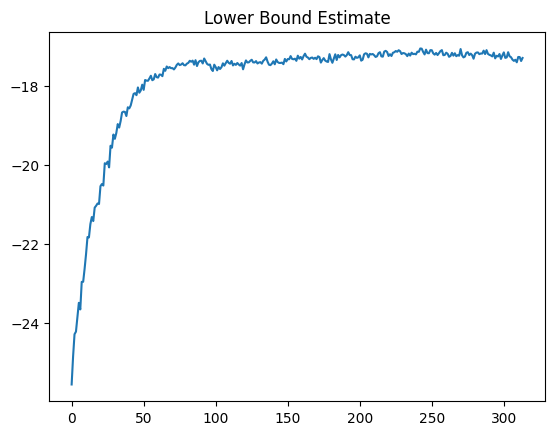

In [44]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

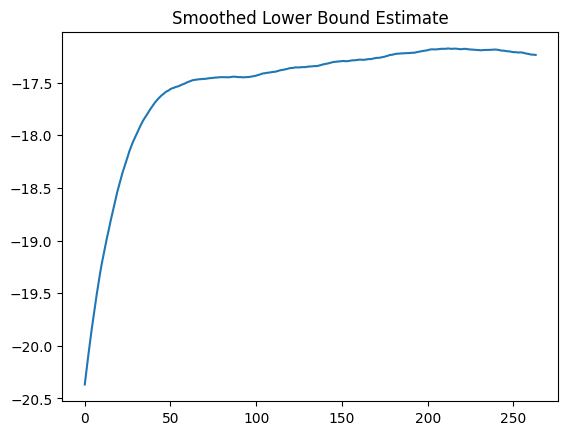

In [45]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [198]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 10000)
best_alpha = best_theta_tilde[0]
best_beta = np.exp(best_theta_tilde[1])
best_gamma = best_theta_tilde[2]
best_delta = np.exp(best_theta_tilde[3])
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([1.05586993, 7.69468505, 1.10547505, 7.40152564])

Text(0.5, 1.0, 'Posterior density of alpha')

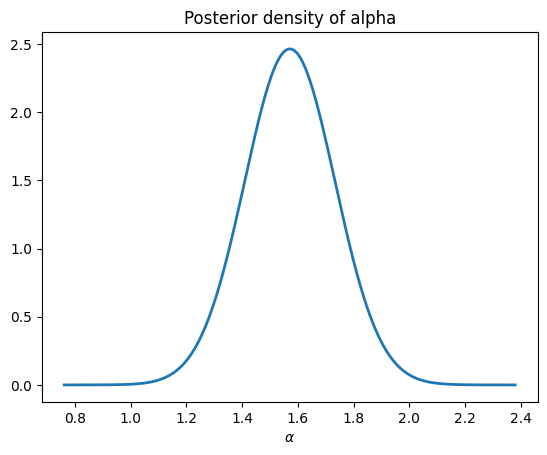

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

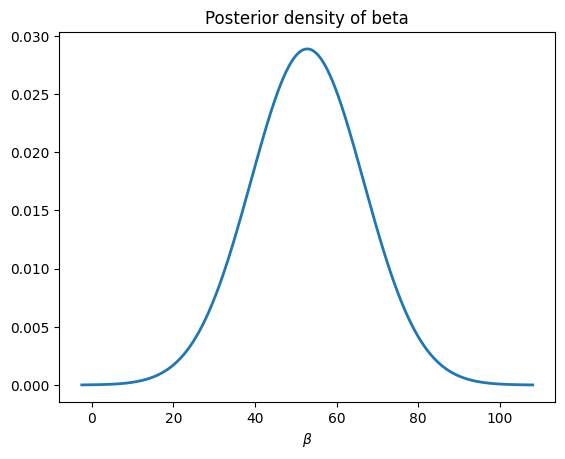

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

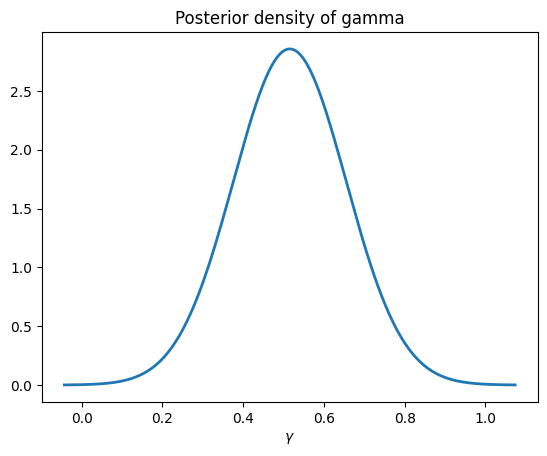

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')